## 번역기 만들기 (1) 데이터 전처리

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
import os
file_path = os.getenv('HOME')+ '/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng','fra','cc'], sep='\t')
print('전체샘플의 수 : ', len(lines))
lines.sample(5) # 샘플 5개 출력

전체샘플의 수 :  217975


,eng,fra,cc
215002,No one knows exactly how many people considere...,Personne ne sait exactement combien de personn...,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
42561,Tom doesn't need it.,Tom n'en a pas besoin.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
72213,I've solved the problem.,J'ai résolu le problème.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
31123,Do you need a ride?,Avez-vous besoin que je vous conduise ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
114791,I'm afraid we're out of time.,Je crains que nous ne soyons pas à l'heure.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
#세번째 열 제거, 훈련데이터 5만개로 줄입니다.
lines = lines[['eng', 'fra']][:50000]
lines.sample(5)

,eng,fra
26480,I want to workout.,Je veux faire de l'exercice.
47292,I think Tom is drunk.,Je pense que Tom est bourré.
43410,We're finally alone.,Nous sommes enfin seules.
26306,I really like you.,Tu me plais vraiment.
12938,Tom knows that.,Tom sait ça.


seq2seq 동작을 위해 디코더의 입력과 예측에는 시작 토큰 <sos>와 종료토큰 <eos>를 추가합니다.

In [4]:
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t ' + x + ' \n')
print('전체 샘플의 수 : ', len(lines))
lines.sample(5)

전체 샘플의 수 :  50000


,eng,fra
29130,Tom seems excited.,\t Tom semble emballé. \n
40085,I will not help you.,\t Je ne t'aiderai pas. \n
45422,Drink a lot of water.,\t Buvez beaucoup d'eau. \n
10944,I followed you.,\t Je t'ai suivi. \n
42260,They need the money.,\t Elles ont besoin de l'argent. \n


단어장(vocabulary)을 만들고 각 단어에 부여된 고유한 정수로 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정을 거칩니다.영어와 프랑스어는 단어장을 별도로 만들어줍니다.


In [5]:
eng_tokenizer = Tokenizer(char_level=True) # 문자단위로 Tokenizer 생성
eng_tokenizer.fit_on_texts(lines.eng) # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng) # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[19, 4, 7], [19, 4, 7], [19, 4, 7]]

In [6]:
fra_tokenizer = Tokenizer(char_level=True) # 문자 단위로 Tokenizer 생성
fra_tokenizer.fit_on_texts(lines.fra) # 50000개의 행을 가진 fra의 각 행에 토큰화 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra) # 단어를 숫자값 인덱스로 변환
target_text[:3]


[[10, 1, 19, 5, 1, 31, 1, 11],
 [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
 [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]

In [7]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73


In [8]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어시퀀스의 최대길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대길이', max_fra_seq_len)

영어시퀀스의 최대길이 21
프랑스어 시퀀스의 최대길이 69


In [9]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73
영어 시퀀스의 최대 길이 21
프랑스어 시퀀스의 최대 길이 69


인코더의 입력으로 사용되는 영어 시퀀스와 달리, 프랑스어 시퀀스는 2가지 버전으로 나누어 준비합니다. 하나는 디코더의 출력과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것이고 다른 하나는 교사강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위함입니다.
디코더의 입력으로 사용할 시퀀스는 <eos> 토큰이 필요 없고, 디코더의 출력과 비교할 정답데이터로 사용해야할 시퀀스는 <sos> 토큰이 필요 없습니다.

In [10]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [11]:
# 디코더의 입력과 출력을 print
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


디코더 입력은 숫자 11(<eos>토큰)가 제거되었고, 디코더 출력은 숫자 10(<sos>토큰)이 제거 되었습니다.
패딩을 진행합니다.

In [12]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21)
프랑스어 입력데이터의 크기(shape) : (50000, 69)
프랑스어 출력데이터의 크기(shape) : (50000, 69)


In [13]:
# 인코더 샘플 하나 출력
print(encoder_input[0])

[19  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


각 정수에 대해서 벡터화 방법으로 원-핫 인코딩을 선택합니다.

In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21, 52)
프랑스어 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 69, 73)


데이터의 크기는 (샘플의수 * 샘플의 길이 * 단어장의 크기)
원-핫 인코딩은 각 정수를 단어장의 크기를 가지는 원-핫 벡터로 인코딩 하는 과정입니다.

훈련과정의 validation을 위해 위에서 생성한 데이터 50000건중 3000건만 validation set으로 잡고, 나머지는 학습데이터로 잡습니다.

In [15]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]     ## ???? -n_of_val
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 21, 52)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 69, 73)


## 번역기 만들기 (2) 모델 훈련하기

*  A ten-minute introduction to sequence-to-sequence learning 을 참고


In [16]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense 
from tensorflow.keras.models import Model

print('⏳')

⏳


#### 인코더 설계
* 인코더의 마지막 hidden state를 디코더의 첫번째 hidden state로 사용합니다. 
* 기본 RNN 보다 좀더 복잡한 LSTM의 경우 hidden state뿐만 아니라 cell state가 존재합니다.
* 인코더 LSTM 셀의 마지막 time step의 hidden state와 cell state를 디코더 LSTM의 첫번째 hidden state와 cell state로 전달해 주어야 합니다.

In [17]:
# 입력 텐서 생성
# LSTM의 입력텐서를 정의합니다. 입력 문장을 저장하게 될 변수 텐서.
encoder_inputs = Input(shape=(None, eng_vocab_size))

# 256의 hidden_size를 가지는 LSTM 셀 생성. LSTM의 수용력(capacity)
# return_state = True를 해서 hidden state와 cell state를 리턴받을 수 있도록 합니다.
encoder_lstm = LSTM(units = 256, return_state = True)

# 입력 텐서를 사용하여 마지막 time step의 hidden state와 cell state를 결과로 받습니다.
# 디코더로 전달할 hidden state, cell state를 리턴. encoder output은 여기서 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# hidden state 와 cell state를 다음 time step으로 전달하기 위해서 별도 저장
# 마지막 time step의 hidden state와 cell state를 encoder_states 라는 하나의 변수에 저장.
# 앞으로 이를 디코더에 전달한다.
encoder_states = [state_h, state_c]

#### 디코더 설계

In [18]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state = encoder_states)

#### 디코더 출력층 설계

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 316416      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [21]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
         validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
         batch_size=128, epochs=50)

Epoch 1/50
368/368 [==============================] - 49s 26ms/step - loss: 0.9511 - val_loss: 0.8141
Epoch 2/50
368/368 [==============================] - 7s 18ms/step - loss: 0.5780 - val_loss: 0.6662
Epoch 3/50
368/368 [==============================] - 7s 18ms/step - loss: 0.4804 - val_loss: 0.5785
Epoch 4/50
368/368 [==============================] - 7s 18ms/step - loss: 0.4250 - val_loss: 0.5348
Epoch 5/50
368/368 [==============================] - 7s 18ms/step - loss: 0.3870 - val_loss: 0.5039
Epoch 6/50
368/368 [==============================] - 7s 18ms/step - loss: 0.3588 - val_loss: 0.4767
Epoch 7/50
368/368 [==============================] - 7s 18ms/step - loss: 0.3367 - val_loss: 0.4518
Epoch 8/50
368/368 [==============================] - 7s 18ms/step - loss: 0.3192 - val_loss: 0.4343
Epoch 9/50
368/368 [==============================] - 7s 18ms/step - loss: 0.3047 - val_loss: 0.4216
Epoch 10/50
368/368 [==============================] - 7s 18ms/step - loss: 0.2925 - val_l

## 번역기 만들기 (3) 모델 테스트 하기

#### 테스트 단계의 디코더 동작 순서
1. 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다.
2. <sos> 토큰인 '\t'를 디코더에 입력한다.
3. 이전 time step의 출력층의 예측결과를 현재 time step의 입력으로 한다.
4. 3을 반복하다가 <eos> 토큰인 '\n'이 예측되면 이를 중단한다. 
    

In [22]:
# 인코더 정의(이미정의한 것 재사용)
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 52)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 316416    
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 디코더 설계
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))

# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))

# 이전 time step의 hidden layer와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence() 에 구현
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)


# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states = [state_h, state_c]

In [24]:
# 디코더의 출력층을 재설계
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_3[0][0]              

In [25]:
# 사전
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [26]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [27]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go.
정답 문장:  Bouge ! 
번역기가 번역한 문장:  partez. 
-----------------------------------
입력 문장: Hello!
정답 문장:  Bonjour ! 
번역기가 번역한 문장:  salut. 
-----------------------------------
입력 문장: Got it!
정답 문장:  Compris ! 
번역기가 번역한 문장:  continue ! 
-----------------------------------
입력 문장: Goodbye.
정답 문장:  Au revoir. 
번역기가 번역한 문장:  cieuss ! 
-----------------------------------
입력 문장: Hands off.
정답 문장:  Pas touche ! 
번역기가 번역한 문장:  tenez votre casse ! 


# 프로젝트 : 단어 Level로 번역기 업그레이드 하기

In [28]:
import tensorflow

print(tensorflow.__version__)
import re

2.6.0


동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical()함수가 아닌 임베딩 층을 추가하여 단어 단위의 번역기를 완성해봅니다. 데이터에서 상위 33,000개의 샘플만 사용합니다. 33000ro wnd 3000개는 테스트 데이터로 분리하여 모델을 학습한 후 번역을 테스트한 용도로 사용합니다.

## step 1. 정제, 정규화, 전처리(영어, 프랑스어)

1. 구두점(punctuation)을 단어와 분리
2. 소문자로
3. 띄어쓰기 단위로 토큰화 수행

In [29]:
lines = lines[['eng', 'fra']][:33000] # 33000개의 샘플 사용
lines.sample(5)

,eng,fra
25640,I checked my bags.,\t J'ai enregistré mes bagages. \n
2769,Am I stupid?,\t Suis-je idiote ? \n
2232,Is it safe?,\t Est-ce inoffensif ? \n
19705,I am on duty now.,\t Maintenant je suis en service. \n
17209,Tom followed me.,\t Tom me suivait. \n


In [30]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = sentence.split()
    
    return sentence

In [31]:
# eng 전처리
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))


In [32]:
lines.eng.sample(5)

23568       [what, s, your, beef, ?]
14886         [i, felt, betrayed, .]
18978       [don, t, be, alarmed, .]
31752    [he, sat, next, to, her, .]
31860    [he, s, working, on, it, .]
Name: eng, dtype: object

## step 2. 디코더의 문장에 시작토큰과 종료토큰 넣기

In [33]:
# 전처리 후 디코더
def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
    

    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = '<sos> ' + sentence + ' <eos>'
    sentence = sentence.split(" ")
    
    return sentence


In [34]:
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

In [35]:
lines.fra.sample(5)

25723    [<sos>, je, ne, dispose, pas, de, beaucoup, de...
16417          [<sos>, personne, ne, l, a, fait, ., <eos>]
378                          [<sos>, moi, aussi, ., <eos>]
13413               [<sos>, quel, chien, massif, !, <eos>]
12958      [<sos>, tom, a, l, air, d, tre, mort, ., <eos>]
Name: fra, dtype: object

## step 3. 케라스의 토크나이저로 텍스트 숫자로 바꾸기

In [37]:
# 영어와 프랑스어에 대한 토크나이저 생성, tokenizer.texts_to_sequences()함수를 사용
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines.eng)

In [38]:
print(eng_tokenizer.word_index)

{'.': 1, 'i': 2, 'you': 3, '?': 4, 'tom': 5, 'it': 6, 's': 7, 'is': 8, 'a': 9, 're': 10, 'we': 11, 't': 12, 'm': 13, 'that': 14, 'he': 15, 'the': 16, 'me': 17, 'this': 18, 'to': 19, 'was': 20, 'are': 21, 'do': 22, '!': 23, 'can': 24, 'they': 25, 'have': 26, 'go': 27, 'don': 28, 'my': 29, 'your': 30, 'be': 31, 'll': 32, 'not': 33, 'what': 34, 'did': 35, 'here': 36, 'no': 37, 'like': 38, 'all': 39, 'let': 40, 'she': 41, 'how': 42, 'in': 43, 'get': 44, 'up': 45, 'need': 46, 'on': 47, 'very': 48, 'want': 49, 'love': 50, 'one': 51, 'who': 52, 'know': 53, 'him': 54, 'come': 55, 'out': 56, 'got': 57, 'please': 58, 'just': 59, 'look': 60, 'now': 61, 'so': 62, 'help': 63, 'there': 64, 'us': 65, 'too': 66, 'stop': 67, 'take': 68, 'of': 69, 'see': 70, 'good': 71, 'will': 72, 'were': 73, 'for': 74, 've': 75, 'am': 76, 'has': 77, 'had': 78, 'at': 79, 'give': 80, 'must': 81, 'where': 82, 'saw': 83, 'keep': 84, 'feel': 85, 'back': 86, 'try': 87, 'home': 88, 'work': 89, 'alone': 90, 'stay': 91, 'didn'

In [40]:
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
input_text[:3]

[[27, 1], [27, 1], [27, 1]]

In [41]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines.fra)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)
target_text[:3]

[[1, 72, 9, 2], [1, 340, 3, 2], [1, 27, 523, 9, 2]]

In [42]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print("영어 사전 크기 : ", eng_vocab_size)
print("프랑스어 사전 크기", fra_vocab_size)

영어 사전 크기 :  4514
프랑스어 사전 크기 7263


In [44]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])

print("영어 시퀀스 최대길이 : ", max_eng_seq_len)
print("프랑스어 시퀀스 최대길이 : ", max_fra_seq_len)

영어 시퀀스 최대길이 :  8
프랑스어 시퀀스 최대길이 :  17


In [45]:
print("전체 샘플의 수 : ",  len(lines))
print("영어 사전 크기 : ", eng_vocab_size)
print("프랑스어 사전 크기", fra_vocab_size)
print("영어 시퀀스 최대길이 : ", max_eng_seq_len)
print("프랑스어 시퀀스 최대길이 : ", max_fra_seq_len)

전체 샘플의 수 :  33000
영어 사전 크기 :  4514
프랑스어 사전 크기 7263
영어 시퀀스 최대길이 :  8
프랑스어 시퀀스 최대길이 :  17


디코더 입력의 종료 토큰 제거, 디코더 출력의 시작 토큰 제거

In [46]:
sos_token = '<sos>'
eos_token = '<eos>'

encoder_input = input_text

# 디코더 입력의 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

#### padding

In [47]:
encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len, padding='post')

print("영어 input 데이터 :", np.shape(encoder_input))
print("프랑스어 input 데이터 : ", np.shape(decoder_input))
print("프랑스어 target 데이터 : ", np.shape(decoder_target))

영어 input 데이터 : (33000, 8)
프랑스어 input 데이터 :  (33000, 17)
프랑스어 target 데이터 :  (33000, 17)


In [51]:
# 33000개중 3000개를 validation set으로 둔다.

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]     ## ???? -n_of_val
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)


(30000, 8)
(30000, 17)
(30000, 17)
(3000, 8)
(3000, 17)
(3000, 17)


## step 4. 임베딩층 사용하기
## step 5.  모델 구현하기

### Train
#### Encoder

인코더에서 사용할 임베딩 층 사용 예시


encoder_inputs = Input(shape=(None,))


enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)


encoder_lstm = LSTM(hidden state의 크기, return_state=True)


encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

In [53]:
encoder_inputs = Input(shape=(None,))
# encoder embedding
enc_emb = Embedding(eng_vocab_size, 256, input_length=max_eng_seq_len)(encoder_inputs)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

##### Decoder

In [55]:
decoder_inputs = Input(shape=(None,))

# decoder embedding
dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_lstm=LSTM(units=256, return_sequences = True, return_state=True)
decoder_outputs,_,_= decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [56]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1155584     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    1859328     input_8[0][0]                    
____________________________________________________________________________________________

label이 integer 값이므로 sparse categorical entropy loss를 사용합니다.

In [57]:
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['acc'])


In [77]:
history = model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
         validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
         batch_size = 32, epochs=50)

Epoch 1/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4419 - acc: 0.9362 - val_loss: 1.1686 - val_acc: 0.8324
Epoch 2/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4395 - acc: 0.9367 - val_loss: 1.1690 - val_acc: 0.8318
Epoch 3/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4376 - acc: 0.9367 - val_loss: 1.1686 - val_acc: 0.8311
Epoch 4/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4361 - acc: 0.9368 - val_loss: 1.1764 - val_acc: 0.8311
Epoch 5/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4347 - acc: 0.9368 - val_loss: 1.1772 - val_acc: 0.8315
Epoch 6/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4330 - acc: 0.9372 - val_loss: 1.1768 - val_acc: 0.8322
Epoch 7/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4315 - acc: 0.9372 - val_loss: 1.1808 - val_acc: 0.8315
Epoch 8/50
938/938 [==============================] - 12s 13ms

In [78]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


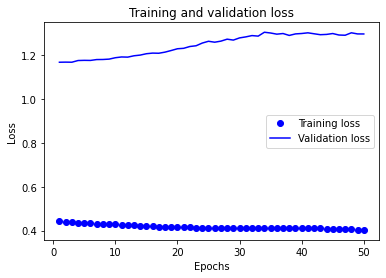

In [80]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Test

##### encoder

In [59]:
encoder_model = Model(inputs = encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         1155584   
_________________________________________________________________
lstm_3 (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 1,680,896
Trainable params: 1,680,896
Non-trainable params: 0
_________________________________________________________________


##### decoder

In [61]:

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [62]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    1859328     input_8[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 256)]        0                                            
____________________________________________________________________________________________

In [63]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [66]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <sos>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [68]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [71]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<sos>']) and i!=fra2idx['<eos>']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [83]:
for seq_index in [1,70,507,1507,1999]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: whose kid is that ? 
정답 문장: qui est cet enfant ? 
번역기가 번역한 문장:  qui venez venez tie
-----------------------------------
입력 문장: will you go there ? 
정답 문장: t y rendras tu ? 
번역기가 번역한 문장:  tiez tu tiez es 
-----------------------------------
입력 문장: you re surrounded . 
정답 문장: vous tes cern e . 
번역기가 번역한 문장:  vous tes tu toi vou
-----------------------------------
입력 문장: go and wake tom up . 
정답 문장: allez r veiller tom . 
번역기가 번역한 문장:  allez tu tu tu t
-----------------------------------
입력 문장: how much is a room ? 
정답 문장: combien co te une chambre ? 
번역기가 번역한 문장:  tiez quel as as pui


## 회고
* 이번 프로젝트에서는 .,소문자 변환, 띄어쓰기, padding등 자연어처리 기법에 있어서 전처리 하는 방법을 알아보았습니다.
* word embedding 과 seq2seq 모델의 훈련결과를 알아보았습니다.
* 음.... 5개만 번역해보았지만 어느정도 맞는 것도 있었지만 잘 안된 부분도 꽤 있었던 것 같습니다. 학습하는데 시간이 오래걸려서 데이터셋을 33000개로 제한했었지만, 아마 데이터셋의 개수를 더 늘리면 성능이 더 좋아질 것으로 기대됩니다.
